In [1]:
import numpy as np
import matplotlib.pyplot as plt
from subprocess import call
from scipy.ndimage import gaussian_filter1d
import os
import pandas as pd
from math import isnan
import random
import glob
import sys
sys.path.append('../')
from package_global_functions import *

extSSDpath = getExternalSSDpath()
if os.path.exists(extSSDpath):
    resPath = extSSDpath + getProjectFoldername() + '/gillespie_sim_ci/results'
else:
    resPath = '/results'

In [2]:
# get stationary time from simulations

def search_time(w,t,evo,sig=0):
    """
    sig=0 -> no gaussian filter; sig != 0 -> apply gaussian filter with this sigma
    """
    if sig:
        evo_mod = gaussian_filter1d(evo, sig)
    else:
        evo_mod = evo
    time = float('nan')
    for i in range(len(evo_mod)-w-1):
        block_avg = np.average(evo_mod[i:i+w])
        if abs(evo_mod[i+w+1] - block_avg) < t:
            time = i+w+1
            break
    return time

def search_time_useStatDif(time, evo, statVal: float, statTime: float):
    evo_dif_to_stat = abs(evo - statVal)
    avgdif = np.average(evo_dif_to_stat[time >= statTime])
    times_below_avgdif = time[evo_dif_to_stat < avgdif]
    if len(times_below_avgdif) > 3:
        max_times_to_use = 3
    else:
        max_times_to_use = len(times_below_avgdif)
    tss = np.average(times_below_avgdif[0:max_times_to_use])
    return tss
    

# from gillespie simulations
def get_tss(w,tol, sig=0):
    global pis, qs, l, lci, N, maxTime, Nrea, ic, ci_kwargs
    pichain = ','.join([str(pi) for pi in pis])
    qchain = ','.join([str(q) for q in qs])
    ci_kwargs_chain = ','.join([str(cikw) for cikw in ci_kwargs])
    simCall = f'python LES_model_gill.py -pis {pichain} -qs {qchain} -l {l} -lci {lci} -ci_kwargs {ci_kwargs_chain} '
    simCall += f'-N {N} -maxTime {maxTime} -Nrea {Nrea} -ic {ic} --time_evo'
    call(simCall, shell=True)
    call('tar -xzf sim_results_evos.tar.gz', shell=True)
    evoFiles = glob.glob('sim_results_evos/*')
    all_tss = []
    for testid,f in enumerate(evoFiles):
        df = pd.read_csv(f)
        tss_rea = []
        for k in range(0,len(pis)+1):
            tss_fi = search_time(w,tol,df[f'f{k}'], sig)
            tss_fi = float(df['time'].iloc[tss_fi])
            tss_rea.append(tss_fi)
        all_tss.append(max(tss_rea))
        # fig, ax = plt.subplots(1,1, figsize=(4,4), constrained_layout=True)
        # ax.set_xscale('symlog')
        # iters = list(range(len(df)))
        # ax.plot(iters, df['f0'], color='r')
        # ax.plot(iters, df['f1'], color='g')
        # ax.plot(iters, df['f2'], color='b')
        # ax.axvline(max(tss_rea), 0, 1)
        # fig.savefig(f'test_tss_{testid}.png')
    return all_tss

def get_tss_gill_v2(w,tol,h,sig=0, execSim=False):
    global pis, qs, l, lci, N, maxTime, Nrea, ic, ci_kwargs
    pichain = '_'.join([str(pi) for pi in pis])
    qchain = '_'.join([str(q) for q in qs])
    ci_kwargs_chain = '_'.join([str(cikw) for cikw in ci_kwargs])
    evoName = f'sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}'
    if execSim: # mandatory to execute simulations, even if evos folder already exists
        pichainExec = ','.join([str(pi) for pi in pis])
        qchainExec = ','.join([str(q) for q in qs])
        ci_kwargs_chainExec = ','.join([str(cikw) for cikw in ci_kwargs])
        simCall = f'python LES_model_gill.py -pis {pichainExec} -qs {qchainExec} -l {l} -lci {lci} -ci_kwargs {ci_kwargs_chainExec} '
        simCall += f'-N {N} -maxTime {maxTime} -Nrea {Nrea} -ic {ic} --time_evo'
        call(simCall, shell=True)
        call('tar -xzf sim_results_evos.tar.gz', shell=True)
        call(f'mv sim_results_evos {evoName}', shell=True)
    if os.path.exists(os.path.exists(evoName)): # folder exits
        evoFiles = glob.glob(f'{evoName}/*')
    elif os.path.exists(f'{evoName}.tar.gz'): # compressed folder exists
        call(f'tar -xzf {evoName}.tar.gz', shell=True)
        evoFiles = glob.glob(f'{evoName}/*')
    else:
        print('No evos folder found, please execute with execSim=True')
        return
    all_tss, tssMax = {}, []
    for k in range(len(pis)+1):
        all_tss[f'f{k}'] = []
    for testid,f in enumerate(evoFiles):
        tevo = pd.read_csv(f)
        tssRea = []
        for k in range(len(pis)+1):
            fevo_smoothed = []
            for i in range(int(maxTime/h)):
                tmin, tmax = h*i, h*(i+1)
                fblock = np.average(tevo.query('time >= @tmin and time < @tmax')[f'f{k}'])
                fevo_smoothed.append(fblock)
            tss = search_time(w,tol,fevo_smoothed)
            all_tss[f'f{k}'].append(tss)
            tssRea.append(tss)
        tssRea = [t for t in tssRea if not isnan(t)]
        if len(tssRea) > 0:
            tssMax.append(max(tssRea))
    return all_tss, tssMax

def get_tss_gill_v3(h, execSim=False):
    global pis, qs, l, lci, N, maxTime, Nrea, ic, ci_kwargs
    pichain = '_'.join([str(pi) for pi in pis])
    qchain = '_'.join([str(q) for q in qs])
    ci_kwargs_chain = '_'.join([str(cikw) for cikw in ci_kwargs])
    evoName = f'sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}'
    if execSim: # mandatory to execute simulations, even if evos folder already exists
        pichainExec = ','.join([str(pi) for pi in pis])
        qchainExec = ','.join([str(q) for q in qs])
        ci_kwargs_chainExec = ','.join([str(cikw) for cikw in ci_kwargs])
        simCall = f'python LES_model_gill.py -pis {pichainExec} -qs {qchainExec} -l {l} -lci {lci} -ci_kwargs {ci_kwargs_chainExec} '
        simCall += f'-N {N} -maxTime {maxTime} -Nrea {Nrea} -ic {ic} --time_evo'
        call(simCall, shell=True)
        call('tar -xzf sim_results_evos.tar.gz', shell=True)
        call(f'mv sim_results_evos {evoName}', shell=True)
    if os.path.exists(os.path.exists(evoName)): # folder exits
        evoFiles = glob.glob(f'{evoName}/*')
    elif os.path.exists(f'{evoName}.tar.gz'): # compressed folder exists
        call(f'tar -xzf {evoName}.tar.gz', shell=True)
        evoFiles = glob.glob(f'{evoName}/*')
    else:
        print('No evos folder found, please execute with execSim=True')
        return
    all_tss, tssMax = {}, []
    for k in range(len(pis)+1):
        all_tss[f'f{k}'] = []
    statTime = 0.8*maxTime
    for testid,f in enumerate(evoFiles):
        tevo = pd.read_csv(f)
        tssRea = []
        for k in range(len(pis)+1):
            fevo_smoothed = []
            for i in range(int(maxTime/h)):
                tmin, tmax = h*i, h*(i+1)
                fblock = np.average(tevo.query('time >= @tmin and time < @tmax')[f'f{k}'])
                fevo_smoothed.append(fblock)
            statVal = np.average(tevo.query('time > @statTime')[f'f{k}'])
            times_smooth = np.arange(0,maxTime,h)
            tss = search_time_useStatDif(times_smooth, fevo_smoothed, statVal, statTime)
            all_tss[f'f{k}'].append(tss)
            tssRea.append(tss)
        tssRea = [t for t in tssRea if not isnan(t)]
        if len(tssRea) > 0:
            tssMax.append(max(tssRea))
    return all_tss, tssMax

# from agent based model simulations
# remain that in fortran code I use the convention of ci modes 1,2,3 for linear,sig1,sig2 respectively!!!
# for this reason cimode=cimode+1 below;)
def get_tss_AB(w,tol, sig=0):
    global pis, qs, l, lci, N, maxTime, Nrea, ic, ci_kwargs
    froute = '../clean_version_ci/'
    fin_file = 'input_template.txt'
    fex_file = 'main.x'
    pichain = ','.join([str(pi) for pi in pis])
    qchain = ','.join([str(q) for q in qs])
    ci_kwargs_chain = ','.join([str(cikw) for cikw in ci_kwargs])
    change_sim_input(froute, fin_file, pis=pis, qs=qs, lamb=l, max_time=maxTime, N_sites=len(pis), N_bots=N, bots_per_site=[N, 0, 0], ic='N', 
                     lci=lci, cimode=ci_kwargs[0]+1)
    if len(ci_kwargs) > 1:
        change_sim_input(froute, fin_file, ci_x0=ci_kwargs[1], ci_a=ci_kwargs[2])
    wd = os.getcwd()
    # Execute simulations:
    os.chdir(froute)
    call("./"+fex_file+f" {random.randint(0,100000000)} {Nrea}", shell=True)
    os.chdir(wd)
    # Save the time evolutions:
    call(f'tar -xzf {froute}time_evo_csv.tar.gz', shell=True)
    # call(f'mv time_evo_csv {newFolderName}', shell=True)
    # call(f'mkdir -p {path}', shell=True)
    # if os.path.exists(f'{path}/{newFolderName}'):
    #     call(f'rm -r {path}/{newFolderName}', shell=True)
    # call(f'mv {newFolderName} {path}', shell=True)
    evoFiles = glob.glob('time_evo_csv/*')
    all_tss = []
    for testid,f in enumerate(evoFiles):
        df = pd.read_csv(f)
        tss_rea = []
        for i in range(0,len(pis)+1):
            tss_fi = search_time(w,tol,df[f'f{i}'], sig)
            tss_rea.append(tss_fi)
        all_tss.append(max(tss_rea))
        # plots for testing:
        # fig, ax = plt.subplots(1,1, figsize=(4,4), constrained_layout=True)
        # ax.set_xscale('symlog')
        # iters = list(range(len(df)))
        # ax.plot(iters, df['f0'], color='r')
        # ax.plot(iters, df['f1'], color='g')
        # ax.plot(iters, df['f2'], color='b')
        # ax.axvline(max(tss_rea), 0, 1)
        # fig.savefig(f'test_tss_{testid}.png')      
    return all_tss

## testing a function for the ss time

62.0
62.666666666666664
62.0


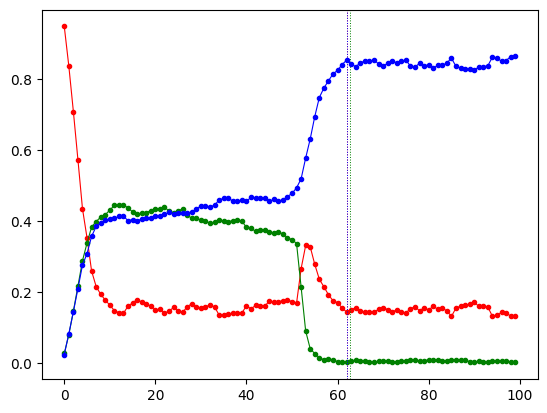

In [14]:
pis, qs = [0.1, 0.1], [9.0, 10.0]
l, lci, N, maxTime, ic = 0.6, 1.0, 1000, 100.0, 'N'
# ci_kwargs = [2, 0.3, 10.0]
ci_kwargs = [1, 0.5, 500.0]
# ci_kwargs = [0, ]

pichain = '_'.join([str(pi) for pi in pis])
qchain = '_'.join([str(q) for q in qs])
ci_kwargs_chain = '_'.join([str(cikw) for cikw in ci_kwargs])
evoName = f'{resPath}/sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}'

# not necessarily ordered:
# evoFiles = glob.glob(f'{evoName}/*')
# tevo = pd.read_csv(evoFiles[38])

evoFiles = glob.glob(f'{evoName}/time_evo_rea_38.csv')

h,w,tol = 1.0, 20, 1e-3
# h,w,tol = 0.5, 5, 5e-3
fs_evos_sm = {}
for f in ['f0', 'f1', 'f2']:
    fevo_smoothed = []
    for i in range(int(maxTime/h)):
        tmin, tmax = h*i, h*(i+1)
        fblock = np.average(tevo.query('time >= @tmin and time < @tmax')[f])
        fevo_smoothed.append(fblock)
    fs_evos_sm[f] = fevo_smoothed

fs_evos_sm['time'] = np.arange(0,maxTime,h)
tevo_smooth = pd.DataFrame(fs_evos_sm)

# SIMPLE SEARCH TIME WITH THE SMOOTHED TIME EVO
# fig, ax = plt.subplots()
# colors = ['r', 'g', 'b']
# for f,c in zip(['f0', 'f1', 'f2'], colors):
#     tss = search_time(w, tol, tevo_smooth[f])
#     ax.plot(tevo_smooth['time'], tevo_smooth[f], color=c, lw=0.8, marker='.')
#     ax.axvline(tss, 0, 1, ls=':', lw=0.7, color=c)
    # compute derivative of the time evo:
    # tevo_deriv = []
    # for i in range(len(tevo_smooth)):
    #     if i == 0: # forward derivative at timestep 0
    #         deriv = (tevo_smooth[f].iloc[1]-tevo_smooth[f].iloc[0])/h
    #     elif i == len(tevo_smooth)-1: # backwards derivative at the last timestep
    #         deriv = (tevo_smooth[f].iloc[-1]-tevo_smooth[f].iloc[-2])/h
    #     else: # central derivative at the last point
    #         deriv = (tevo_smooth[f].iloc[i+1]-tevo_smooth[f].iloc[i-1])/(2*h)
    #     tevo_deriv.append(abs(deriv))
    # ax.plot(tevo_smooth['time'], tevo_deriv, color=c, lw=0.7)
    # ax.set_yscale('log')
    # ax.axhline(1e-4, 0, 1, ls=':', color='k', lw=0.7)


# COMPUTE THE STATIONARY VALUE AND COMPARE HOW THE SMOOTHED TIME EVO DRIFTS AWAY FROM END TO START:
stat_vals = {}
statTime = 0.8*maxTime
for f in ['f0', 'f1', 'f2']:
    stat_vals[f] = np.average(tevo.query('time > @statTime')[f])

fig, ax = plt.subplots()
colors = ['r', 'g', 'b']
for f,c in zip(['f0', 'f1', 'f2'], colors):
    tevo_smooth[f'dif_{f}'] = abs(tevo_smooth[f] - stat_vals[f])
    tevo_smooth[f'rel_dif_{f}'] = abs(tevo_smooth[f] - stat_vals[f])/stat_vals[f]
    # ax.plot(tevo_smooth['time'], tevo_smooth[f'dif_{f}'], color=c, lw=0.8, marker='.')
    # ax.plot(tevo_smooth['time'], tevo_smooth[f'rel_dif_{f}'], color=c, lw=0.8, marker='.')
    # ax.set_yscale('log')
    # ax.axhline(0.5, 0, 1, ls=':', lw=0.7, color='k')
    # ax.axhline(1.0, 0, 1, ls=':', lw=0.7, color='k')
    avgdif = np.average(tevo_smooth.query('time > @statTime')[f'dif_{f}'])
    times_below_avgdif = np.array(tevo_smooth.query(f'dif_{f} <= @avgdif')['time'])
    times_rel_dif_over1 = np.array(tevo_smooth.query(f'rel_dif_{f} >= 1')['time'])
    if len(times_rel_dif_over1) > 0:
        mintss = max(times_rel_dif_over1)
    else:
        mintss = 0
    # refined times: combine times below avgdif while considering if there are times with a large fluctiation (reldif >= 1), and condidering only above them
    refinedTimes = np.array(tevo_smooth.query(f'dif_{f} <= @avgdif & time > @mintss')['time'])
    # tss = np.average(times_below_avgdif[0:3])
    tss = np.average(refinedTimes[0:3])
    print(tss)
    # print(tss, times_below_avgdif[0:3])
    ax.plot(tevo_smooth['time'], tevo_smooth[f], color=c, lw=0.8, marker='.')
    ax.axvline(tss, 0, 1, ls=':', lw=0.7, color=c)


# Using Gillespie Simulations

In [ ]:
pis, qs = [0.1, 0.1], [9.0, 10.0]
l, lci, N, maxTime, Nrea, ic = 0.6, 1.0, 500, 90.0, 5, 'N'
ci_kwargs = [2, 0.3, 10.0]
w, tol = 1000, 1e-4
sig = 0.2
times = get_tss(w, tol, sig)

In [ ]:
sig = 50
for i,tss in enumerate(times):
    tevo = pd.read_csv(f'sim_results_evos/time_evo_rea_{i}.csv')
    fig, ax = plt.subplots(constrained_layout=True)
    if sig > 0:
        ax.plot(tevo['time'], gaussian_filter1d(tevo['f0'],sig), color='xkcd:red')
        ax.plot(tevo['time'], gaussian_filter1d(tevo['f1'],sig), color='xkcd:green')
        ax.plot(tevo['time'], gaussian_filter1d(tevo['f2'],sig), color='xkcd:blue')
    else:
        ax.plot(tevo['time'], tevo['f0'], color='xkcd:red')
        ax.plot(tevo['time'], tevo['f1'], color='xkcd:green')
        ax.plot(tevo['time'], tevo['f2'], color='xkcd:blue')
    ax.axvline(tss, 0,1, color='k', ls=':')
    fig.savefig(f'time_evo_rea_{i}_tss_trial.png')

In [49]:
all_tss, tssMax = get_tss_gill_v2(5,5e-3,1.0, execSim=False)

In [22]:
pis, qs = [0.1, 0.1], [9.0, 10.0]
l, lci, N, maxTime, Nrea, ic = 0.3, 1.0, 1000, 90.0, 25, 'N'
ci_kwargs = [2, 0.3, 10.0]

w, tol, h = 5, 1e-3, 1.0

ci_kwargs = [2, 0.3, 10.0]
# all_fs_timesSig2, timesMaxSig2 = get_tss_gill_v2(w, tol, h)
all_fs_timesSig2, timesMaxSig2 = get_tss_gill_v3(h)
print(f'Avg: {np.average(timesMaxSig2)} std: {np.std(timesMaxSig2)}')

ci_kwargs = [0, ]
# all_fs_timesLin, timesMaxLin = get_tss_gill_v2(w, tol, h)
all_fs_timesLin, timesMaxLin = get_tss_gill_v3(h)
print(f'Avg: {np.average(timesMaxLin)} std: {np.std(timesMaxLin)}')

Avg: 37.15 std: 8.521525033049477
Avg: 67.60000000000001 std: 8.918520056601318


In [23]:
for all_times in [all_fs_timesSig2, all_fs_timesLin]:
    timesClean = []
    for times in all_times.values():
        timesfClean = [t for t in times if not isnan(t)]
        timesClean.extend(timesfClean)
    print(np.average(timesClean))

34.31111111111111
63.71111111111111


### Visual comparison of different ci modes sims

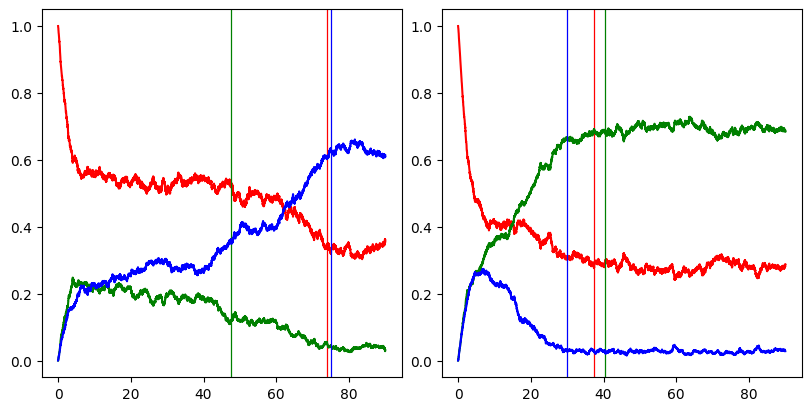

In [26]:
pis, qs, l, lci, N, ic = [0.1, 0.1], [9.0, 10.0], 0.3, 1.0, 1000, 'N'
ci_kwargs_list = [[0, ], [2, 0.3, 10.0]]

pichain = '_'.join([str(pi) for pi in pis])
qchain = '_'.join([str(q) for q in qs])

# fig, ax = plt.subplots(1,1, constrained_layout=True)
fig, ax = plt.subplots(1,2, figsize=(8,4), constrained_layout=True)
evoID = 11
# for ci_kwargs,ls in zip(ci_kwargs_list, ['-', '-.']):
for i,(ci_kwargs,all_times) in enumerate(zip(ci_kwargs_list, [all_fs_timesLin, all_fs_timesSig2])):
    ci_kwargs_chain = '_'.join([str(cikw) for cikw in ci_kwargs])
    evoName = f'sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}'
    if not os.path.exists(f'{evoName}/'):
        call(f'tar -xzf {evoName}.tar.gz', shell=True)
        call(f'mv sim_results_evos {evoName}', shell=True)
    evoFiles = glob.glob(f'{evoName}/*')
    tevo = pd.read_csv(f'{evoFiles[evoID]}')
    # ax.plot(tevo['time'], tevo['f2'], ls=ls, lw=0.9)
    for j,c in enumerate(['r', 'g', 'b']):
        ax[i].plot(tevo['time'], tevo[f'f{j}'], color=c)
        ax[i].axvline(all_times[f'f{j}'][evoID], 0, 1, color=c, lw=0.9)
    

# Using agent based model

In [ ]:
pis, qs = [0.1, 0.1], [9.0, 10.0]
l, lci, N, maxTime, Nrea, ic = 0.6, 1.0, 500, 3000, 5, 'N'
ci_kwargs = [2, 0.3, 10.0]
w, tol = 50, 1e-4
times = get_tss_AB(w, tol)

In [ ]:
for i,tss in enumerate(times):
    tevo = pd.read_csv(f'time_evo_csv/time_evo_rea_{str(i+1).zfill(3)}.csv')
    fig, ax = plt.subplots(constrained_layout=True)
    ax.set_xscale('symlog')
    ax.plot(tevo['iter'], tevo['f0'], color='xkcd:red')
    ax.plot(tevo['iter'], tevo['f1'], color='xkcd:green')
    ax.plot(tevo['iter'], tevo['f2'], color='xkcd:blue')
    ax.axvline(tss, 0,1, color='k', ls=':')
    fig.savefig(f'time_evo_rea_AB_{i}_tss_trial.png')

In [ ]:
w, tol = 50, 1e-4

In [ ]:
maxTime = 2000
Nrea = 10
ci_kwargs = [2, 0.3, 10.0]
times = get_tss_AB(w, tol)
print(np.average(times))

In [ ]:
ci_kwargs = [0, ]
times = get_tss_AB(w, tol)
print(np.average(times))